In [1]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np

from lmfit import minimize, Parameters, Model
from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel , StepModel#Modelli vari, l'ultimo è Fermi (o Bose)
from lmfit.model import Model, save_model

Welcome to JupyROOT 6.30/04


In [2]:
channel= 0

In [3]:
#Tensione per considerare il segnale come saturato
Vt = np.array([-1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.5, -1.3, 
               -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3]) #V
#Carica per filtrare spike ed eventi triggerati male
Q_max = np.array([-30, -30, -30, -30, -30, -30, -30, -30, 
                  -30, -30, -30, -30, -30, -30, -30, -30, ]) #pC
#Carica per filtrare cosmici
Q_min = np.array([-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 
                  -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, ]) #pC

Vt = Vt[channel]
Q_max = Q_max[channel]
Q_min = Q_min[channel]

In [5]:
PATH = '../Dati/Dati_belli/Ch'+str(channel)+'/Run_ch' + str(channel) + '_Cs_Measurements_Only_4_3_2024_0000.root' #Percorso relativo del file da analizzare
RunCs = uproot.open(PATH) #Apertura file da analizzare

noise_file = '../Dati/Dati_belli/Ch'+str(channel)+'/Run_ch' + str(channel) + '_X_Measurements_Only_4_3_2024_0000.root'  #File di rumore di riferimento per il canale
RunNoise = uproot.open(noise_file)  #Apertura rumore



In [6]:
chargeCs = np.array(RunCs['tree'].arrays()['charge'])
ampCs = np.array(RunCs['tree'].arrays()['amp'])


chargeN = np.array(RunNoise['tree'].arrays()['charge'])
ampN = np.array(RunNoise['tree'].arrays()['amp'])
"""
chargeN = np.append(chargeN_, np.array(RunNoise2['tree'].arrays()['charge']))
ampN_ = np.array(RunNoise2['tree'].arrays()['amp'])
ampN=np.append(ampN_, np.array(RunNoise['tree'].arrays()['amp']))
"""
evCsT = np.array(RunCs['tree'].arrays()['ev'])[-1]
evNT = np.array(RunNoise['tree'].arrays()['ev'])[-1]
print(evCsT, evNT, len(chargeN), len(ampN))

1000000 300000 300000 300000


In [7]:
trueCs = ampCs>Vt  #Seleziono solo gli eventi che non saturano
chargeCs = chargeCs[trueCs]
ampCs=ampCs[trueCs]

trueCs = (chargeCs < Q_max) & (chargeCs > Q_min)
chargeCs = chargeCs[trueCs] #Seleziono solo gli eventi con una carica sotto una certa soglia
ampCs=ampCs[trueCs]         #così da trascurare spike ed eventi dovuti a trigger su altro canale


trueX = ampN>Vt             #Procedo allo stesso modo per "ripulire" il rumore
chargeN = chargeN[trueX]
ampN=ampN[trueX]

trueX = (chargeN < Q_max) & (chargeN > Q_min)
chargeN = chargeN[trueX]
ampN=ampN[trueX]

print("#Eventi ripuliti su ch " + str(channel) + " = " + str(len(chargeCs)))
print("#Noise ripulita su ch " + str(channel) + " = " + str(len(chargeN)))

#Eventi ripuliti su ch 0 = 906223
#Noise ripulita su ch 0 = 246046


In [42]:
print(ampCs)

[-0.038758 -0.039743 -0.077144 ... -0.044972 -0.04768  -0.080053]


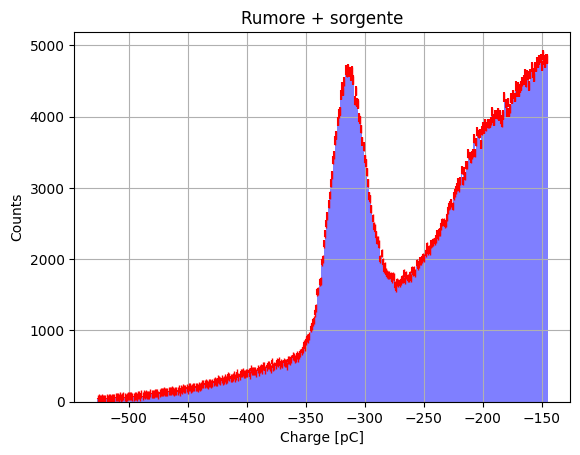

In [49]:
Nbin = 400
bin_lims = [int(Nbin *48 / 100), int(Nbin * 88/ 100)] #Scelgo gli estremi
_, edges, _ = plt.hist(chargeCs, bins = Nbin, color = "r")
plt.clf()
lims = [edges[bin_lims[0]], edges[bin_lims[1]]]
binCs, edgesCs, _ = plt.hist(chargeCs, bins = Nbin, range = lims, color = "b", alpha = 0.5)
centersCs = np.convolve(edgesCs, [0.5, 0.5], "valid")
errCs = np.sqrt(binCs)

plt.errorbar(centersCs, binCs, errCs, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore + sorgente")

plt.show()


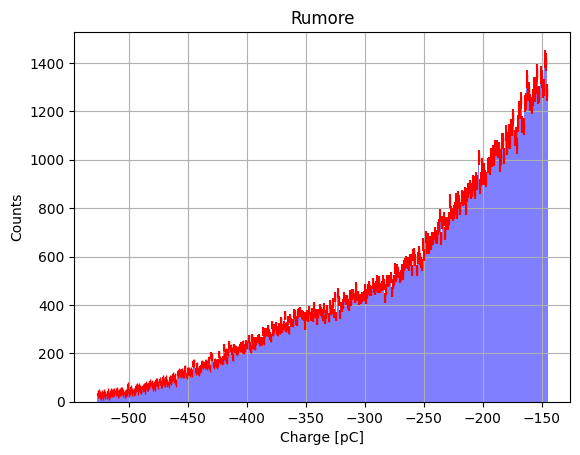

185343.0

In [50]:
binN, edgesN, _ = plt.hist(chargeN, bins = Nbin, range = lims, color = "b", alpha = 0.5)
centersN = np.convolve(edgesN, [0.5, 0.5], "valid")
errN = np.sqrt(binN)
plt.errorbar(centersN, binN, errN, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore")

plt.show()

binN.sum()

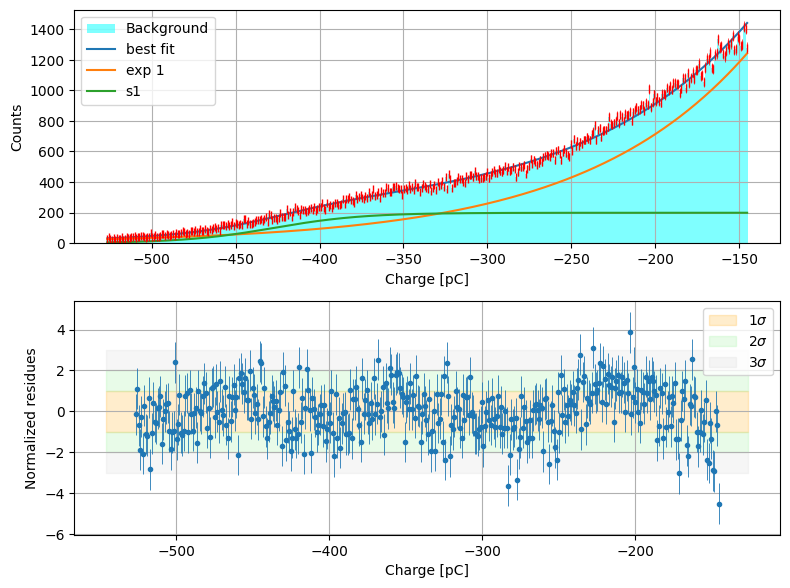

[[Model]]
    (Model(exponential, prefix='e1_') + Model(step, prefix='s1_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 118
    # data points      = 400
    # variables        = 5
    chi-square         = 578.955992
    reduced chi-square = 1.46571137
    Akaike info crit   = 157.904768
    Bayesian info crit = 177.862091
    R-squared          = 0.99998918
[[Variables]]
    e1_amplitude:  5411.45191 +/- 160.267113 (2.96%) (init = 6541.264)
    e1_decay:     -98.6634287 +/- 2.30568295 (2.34%) (init = -109.534)
    g2_amplitude:  1358769 (fixed)
    g2_center:    -228.2376 (fixed)
    g2_sigma:      93.65655 (fixed)
    g2_fwhm:       220.544320 +/- 0.00000000 (0.00%) == '2.3548200*g2_sigma'
    g2_height:     5787.85489 +/- 0.00000000 (0.00%) == '0.3989423*g2_amplitude/max(1e-15, g2_sigma)'
    s1_amplitude:  198.537382 +/- 12.9066411 (6.50%) (init = 100)
    s1_center:    -427.354656 +/- 1.68545770 (0.39%) (init = -380)
    s1_sigma: 

name,value,standard error,relative error,initial value,min,max,vary,expression
e1_amplitude,5411.45191,160.267113,(2.96%),6541.263570925446,0.00000000,inf,True,
e1_decay,-98.6634287,2.30568295,(2.34%),-109.53401925417337,-inf,inf,True,
g2_amplitude,1358769.25,0.00000000,(0.00%),1358769.2471466064,-inf,inf,False,
g2_center,-228.237600,0.00000000,(0.00%),-228.23760018832442,-inf,inf,False,
g2_sigma,93.6565514,0.00000000,(0.00%),93.65655136108398,0.00000000,inf,False,
g2_fwhm,220.544320,0.00000000,(0.00%),220.5443202761078,-inf,inf,False,2.3548200*g2_sigma
g2_height,5787.85489,0.00000000,(0.00%),5787.8548884,-inf,inf,False,"0.3989423*g2_amplitude/max(1e-15, g2_sigma)"
s1_amplitude,198.537382,12.9066411,(6.50%),100.0,-inf,inf,True,
s1_center,-427.354656,1.68545770,(0.39%),-380.0,-inf,inf,True,
s1_sigma,26.6601808,2.14848027,(8.06%),20,5.00000000,inf,True,


In [51]:
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
#gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
gauss2 = GaussianModel(prefix='g2_')    #Gaussiana
s1    = StepModel(form = "logistic", prefix = "s1_") #Fermi Dirac1
s2    = StepModel(form = "logistic", prefix = "s2_") #Fermi Dirac



 
params = exp1.guess(binN, x=centersN)           #Inizializzo i parametri dell'esponenziale
params.update(gauss2.make_params(amplitude = 1000, center = -370, sigma = 25)) #Imposta la seconda gaussiana con A = 0 (necessario per primo fit)
params.update(gauss2.guess(binCs, x=centersCs))
params.update(s1.make_params(amplitude = 100, center = -380, sigma = 20))    #Imposta la Fermi Dirac con A = 0 (necessario per primo fit) 
params.update(s2.make_params(amplitude = 0, center = -200, sigma = 50))



params["g2_amplitude"].vary = False    #Blocco i parametri della seconda gaussiana e della 
params["g2_center"].vary = False       #Fermi Dirac: non servono nel primo fit
params["g2_sigma"].vary = False

params["s2_amplitude"].vary= False
params["s2_center"].vary=False
params["s2_sigma"].vary=False

params["e1_amplitude"].min=0
params["s1_sigma"].set(value=20, min=5)

model = exp1 + s1 

# Fit the model to the data
result = model.fit(binN, params, x = centersN, weights = 1/errN, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeN, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersN, result.best_fit, label='best fit')
ax1.plot(centersN, comps['e1_'], label='exp 1')
ax1.plot(centersN, comps['s1_'], label='s1')


ax1.legend()
ax1.errorbar(centersN, binN, errN, color = "red", fmt='|', linewidth=0.5)
ax1.grid()

residueN = binN - result.best_fit
norm_resN = residueN / errN

ax2.errorbar(centersN, norm_resN, 1, ls = "", marker = ".", linewidth=.6)
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())

frac=result.params["e1_amplitude"].value/result.params["s1_amplitude"].value
print(frac)
params.update(result.params)

Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude      5411        0      inf    160.3     True     None     None
e1_decay        -98.66     -inf      inf    2.306    False     None     None
g2_amplitude  1.359e+06     -inf      inf        0     True     None     None
g2_center         -320     -inf      inf        0     True     None     None
g2_fwhm          44.74     -inf      inf        0    False 2.3548200*g2_sigma     None
g2_height     2.853e+04     -inf      inf        0    False 0.3989423*g2_amplitude/max(1e-15, g2_sigma)     None
g2_sigma            19        0      inf        0     True     None     None
s1_amplitude     198.5     -inf      inf    12.91    False e1_amplitude/27.256589479603228     None
s1_center       -427.4     -inf      inf    1.685    False     None     None
s1_sigma         26.66        5      inf    2.148    False     None     None
s2_amplitude      5000     -inf      inf        0     True     None     None
s2_c

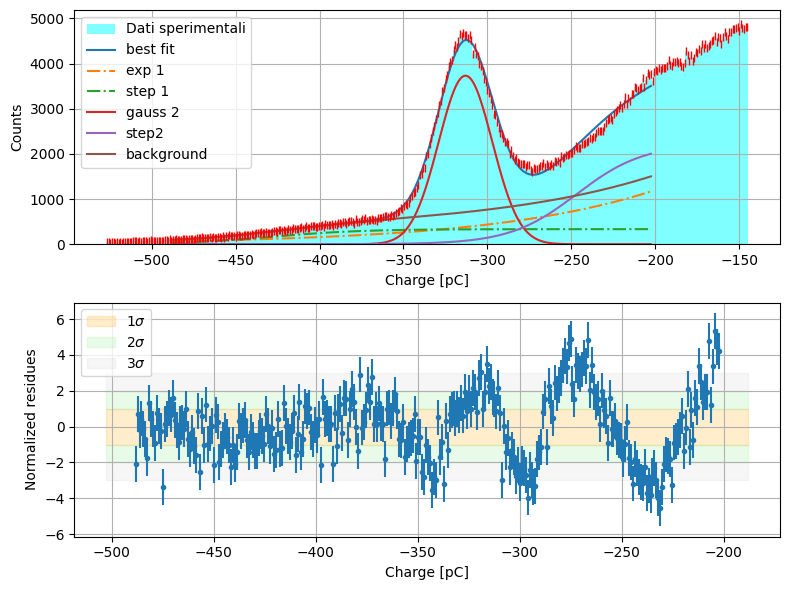

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(step, prefix='s1_', form='logistic')) + Model(gaussian, prefix='g2_')) + Model(step, prefix='s2_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 99
    # data points      = 300
    # variables        = 7
    chi-square         = 1038.88462
    reduced chi-square = 3.54568129
    Akaike info crit   = 386.636138
    Bayesian info crit = 412.562615
    R-squared          = 0.99999811
[[Variables]]
    e1_amplitude:  9100.53226 +/- 84.8244306 (0.93%) (init = 5411.452)
    e1_decay:     -98.66343 (fixed)
    g2_amplitude:  149726.105 +/- 1353.41998 (0.90%) (init = 1358769)
    g2_center:    -313.041453 +/- 0.12792508 (0.04%) (init = -320)
    g2_sigma:      16.0088210 +/- 0.12404301 (0.77%) (init = 19)
    g2_fwhm:       37.6978919 +/- 0.29209896 (0.77%) == '2.3548200*g2_sigma'
    g2_height:     3731.19774 +/- 27.2543305 (0.73%) == '0.3989423*g2_amplitude/max(1e-15, g2_sigma)'
    s1_

In [56]:

params["e1_decay"].vary = False
#params["e1_amplitude"].set()

params["g2_amplitude"].set(vary = True)
params["g2_center"].set(value= -320, vary = True)
params["g2_sigma"].set(value=19, vary = True)

params["s2_amplitude"].set(value=5000,  vary= True)
params["s2_center"].set(value=-235,   vary=True)
params["s2_sigma"].set(value=30, min=1, max=20,   vary=True)

params["s1_amplitude"].set(vary = True, expr='e1_amplitude/'+str(frac))
params["s1_center"].set(vary = False)
params["s1_sigma"].vary = False


model = exp1 + s1 + gauss2 +s2

params.pretty_print()

start=int(Nbin *10/ 100)
stop=int(Nbin * 85/ 100)

# Fit the model to the data
result = model.fit(binCs[start:stop], params, x = centersCs[start:stop], weights = 1/errCs[start:stop])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeCs, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Dati sperimentali")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.errorbar(centersCs, binCs, errCs, color = "red", fmt='|', linewidth=.6)
ax1.plot(centersCs[start:stop], result.best_fit, label='best fit')
ax1.plot(centersCs[start:stop], comps['e1_'], '-.', label='exp 1', )
ax1.plot(centersCs[start:stop], comps['s1_'], '-.', label='step 1')
ax1.plot(centersCs[start:stop], comps['g2_'], label='gauss 2')
ax1.plot(centersCs[start:stop], comps['s2_'], label='step2')
ax1.plot(centersCs[start:stop], comps['s1_']+comps['e1_'], label='background')


ax1.legend()
ax1.grid()

residueCs = binCs[start:stop] - result.best_fit
norm_resCs = residueCs / errCs[start:stop]

ax2.errorbar(centersCs[start:stop], norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())